# Run this code after running Classic RBA$_\theta$ simulation.
##### "You might need to change the paths only, check before running."

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import timedelta
import matplotlib.dates as mdates

In [3]:
# === Load Data ===
df = pd.read_excel('/Users/purbaksengupta/Downloads/rbaTheta-master_2/input_data/data_2/scada_summer.xlsx',
                   parse_dates=['DateTime'], index_col='DateTime')

sig_norm = pd.read_excel('/Users/purbaksengupta/Downloads/rbaTheta-master_2/simulations/test_results/all_events/significant_events_T_0.1.xlsx').reset_index()
stat_norm = pd.read_excel('/Users/purbaksengupta/Downloads/rbaTheta-master_2/simulations/test_results/all_events/stationary_events_T_0.1.xlsx').reset_index()

# === Choose default turbine and time ===
start = pd.to_datetime("2018-06-01 00:00:00")
turbine = df.columns[0]

In [4]:
def plot_rba_events(df, sig_events, stat_events, turbine, start_time, hours, save_path):
    from matplotlib import dates as mdates
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from datetime import timedelta

    end_time = start_time + timedelta(hours=hours)
    df_window = df[turbine].loc[start_time:end_time]

    fig, ax = plt.subplots(figsize=(16, 6))

    # Plot original data in blue
    ax.plot(df_window.index, df_window.values, color='blue', linewidth=1.2, label='Original Data', zorder=1)

    # Plot up-ramp and down-ramp segments
    for _, row in sig_events.iterrows():
        t1, t2 = int(row['t1']), int(row['t2'])
        if 0 <= t1 < len(df) and 0 <= t2 < len(df):
            t1_time, t2_time = df.index[t1], df.index[t2]
            if t2_time <= start_time or t1_time >= end_time:
                continue
            seg = df[turbine].loc[t1_time:t2_time]
            if not seg.empty:
                color = 'red' if row.get('∆w_m', 0) > 0 else 'green'
                ax.plot(seg.index, seg.values, color=color, linewidth=1.8, zorder=2)

    # Plot stationary events as horizontal gray lines
    for _, row in stat_events.iterrows():
        t1, t2 = int(row['t1']), int(row['t2'])
        if 0 <= t1 < len(df) and 0 <= t2 < len(df):
            t1_time, t2_time = df.index[t1], df.index[t2]
            if t2_time <= start_time or t1_time >= end_time:
                continue
            seg = df[turbine].loc[t1_time:t2_time]
            if not seg.empty:
                y_val = seg.mean()
                ax.hlines(y=y_val, xmin=t1_time, xmax=t2_time, color='gray', linewidth=2, alpha=0.8, zorder=3)

    # Plot settings
    ax.set_title(f"Turbine 1: RBAθ {'MCMC' if 'mcmc' in save_path.lower() else 'Traditional'} Events from {start_time.date()} to {end_time.date()}",
                 fontsize=11)
    ax.set_ylabel("Normalized Power")
    ax.set_xlim(start_time, end_time)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_facecolor("white")

    # Legend
    patches = [
        mpatches.Patch(color='blue', label='Original Data'),
        mpatches.Patch(color='red', label='Up-ramp Events'),
        mpatches.Patch(color='green', label='Down-ramp Events'),
        mpatches.Patch(color='gray', alpha=0.8, label='Stationary Events'),
    ]
    ax.legend(handles=patches, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.15), fontsize=9, frameon=False)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

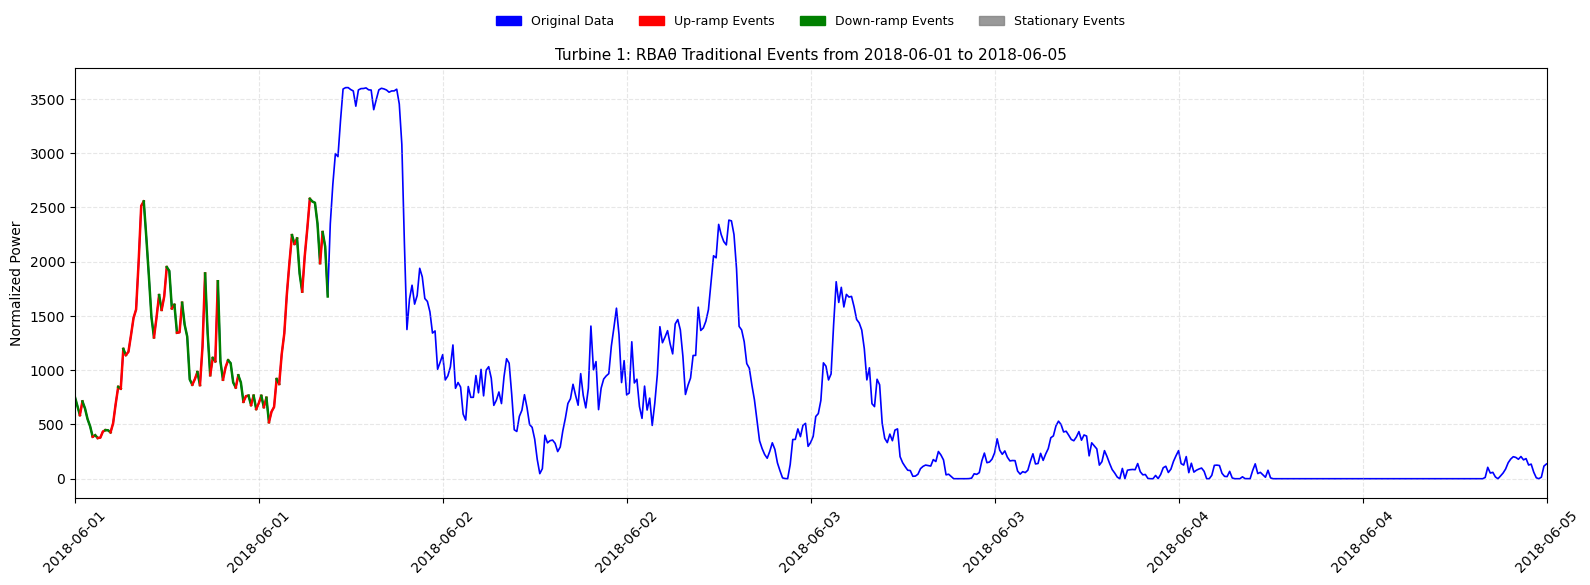

In [9]:
plot_rba_events(df, sig_norm, stat_norm, turbine, start, 96, "rbaTheta_24h.png")